In [2]:
%matplotlib inline
import os, pickle
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

font_path = "/home/zhoujb/local/font/Times New Roman.ttf"
mpl.font_manager.fontManager.addfont(font_path)
prop = mpl.font_manager.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

RAW_PATH = "/data2/zhoujb/project/cowpea_project/rawData/"
SNP_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/snpDir/"
CLUSTER_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/SNPMMSeqCluster/"
RES_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/Result/"
FIG_PATH = "/data2/zhoujb/project/cowpea_project/basedXPXLR/plotFigure/"

In [3]:
#raw_phenos = pd.read_excel(os.path.join(RAW_PATH, "Phenotypes for GWAS-upload public database.xlsx"), index_col="Accessions")
raw_phenos_1 = pd.read_excel(os.path.join(RAW_PATH, "Phenotypes for GWAS-upload public database.xlsx"), index_col="Accessions")
raw_phenos_2 = pd.read_excel(os.path.join(RAW_PATH, "BMK21067-AK808-data-2.xlsx"), index_col="BMK-ID")
raw_phenos_2 = raw_phenos_2[['HZ Pod Cellulose (mg/g)', 'GZ Pod Cellulose (mg/g)', 'HZ Seed Cellulose (mg/g)', 'GZ Seed Cellulose (mg/g)']].copy()
raw_phenos = raw_phenos_1.merge(raw_phenos_2, how='left', left_index=True, right_index=True)

raw_phenos = raw_phenos.drop(columns="ID")
raw_phenos = raw_phenos.replace({"-":np.nan})
raw_phenos = raw_phenos.dropna(axis=0, how="all")
raw_phenos = raw_phenos.rename(columns={'HZ-Pod length':'HZ-PL', 'GZ-Pod length':'GZ-PL', 
                                        'HZ Pod Sugar content (mg/g)':'HZ-PSugar','GZ Pod Sugar content  (mg/g)':'GZ-PSugar', 
                                        'HZ Pod Starch content(mg/g)':'HZ-PStarch','GZ Pod Strach Content (mg/g)':'GZ-PStarch', 
                                        'HZ Pod Protein content(g/Kg)':'HZ-PProtein','GZ Pod protein  (g/Kg)':'GZ-PProtein', 
                                        'HZ Seed Sugar (mg/g)':'HZ-SSuger','GZ Seed Sugar (mg/g)':'GZ-SSuger', 
                                        'HZ Seed Starch (mg/g)':'HZ-SStarch','GZ Seed Starch (mg/g)':'GZ-SStarch', 
                                        'HZ Seed Protein (g/kg)':'HZ-SProtein','GZ Seed Protein (g/kg)':'GZ-SProtein', 
                                        'Pod shattering':'PS', 'HZ Pod Cellulose (mg/g)':"HZ-PC", 'GZ Pod Cellulose (mg/g)':"GZ-PC",
                                        'HZ Seed Cellulose (mg/g)':"HZ-SC", 'GZ Seed Cellulose (mg/g)':"GZ-SC"})

samples_score_info = pd.read_table(os.path.join(RES_PATH, "Samples_Score_Info.tsv"), index_col="Sample")
samples_score_info = samples_score_info.drop(columns=[ 'Class', 'Mis_Hap_Num'])
samples_score_info = samples_score_info.rename(columns={'Hap_Score.by_Total_pop':'Total_score', 
                                                        'Hap_Score.by_VL_pop':'VL_score',
                                                        'Hap_Score.by_G_pop':'G_score',
                                                        'Hap_Score.by_VC_pop':'VC_score'})
samples_score_info = samples_score_info[["Total_score"]]

inte_sample_list = list(set(raw_phenos.index).intersection(samples_score_info.index.to_list()))
raw_phenos = raw_phenos.loc[inte_sample_list]
samples_score_info = samples_score_info.loc[inte_sample_list]

phenos_add_score = pd.concat([raw_phenos, samples_score_info], axis=1)

with open("./haha_tmp..pkl", 'wb') as f:
    pickle.dump(phenos_add_score, f)

#corr_pearson = phenos_add_score.corr()
#corr_spearman = phenos_add_score.corr(method='spearman')

pear_corr_df = pd.DataFrame(np.nan, columns=phenos_add_score.columns, index=phenos_add_score.columns)
pear_pvals_df = pd.DataFrame(np.nan, columns=phenos_add_score.columns, index=phenos_add_score.columns)
spear_corr_df = pd.DataFrame(np.nan, columns=phenos_add_score.columns, index=phenos_add_score.columns)
spear_pvals_df = pd.DataFrame(np.nan, columns=phenos_add_score.columns, index=phenos_add_score.columns)

for index in phenos_add_score.columns:
    for col in phenos_add_score.columns:
        if index == col:
            pear_corr_df.loc[index, col] = 1
            pear_pvals_df.loc[index, col] = 0
            spear_corr_df.loc[index, col] = 1
            spear_pvals_df.loc[index, col] = 0
        else:
            tmp_data = phenos_add_score[[index, col]].copy()
            tmp_data = tmp_data.dropna()

            data_index = tmp_data[index].values
            data_col = tmp_data[col].values

            pear_val, pear_pval = stats.pearsonr(data_index, data_col)
            spear_val, spear_pval = stats.spearmanr(data_index, data_col)

            pear_corr_df.loc[index, col] = pear_val
            pear_pvals_df.loc[index, col] = pear_pval
            spear_corr_df.loc[index, col] = spear_val
            spear_pvals_df.loc[index, col] = spear_pval

# 函数：根据 p 值返回星号
def get_star_significance(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# 创建一个与相关系数矩阵相同大小的注释矩阵
pear_annot = pear_corr_df.round(3).astype(str)  # 将相关系数矩阵转换为字符串格式
for i in range(len(pear_pvals_df)):
    for j in range(len(pear_pvals_df)):
        if i < j:  # 只在上三角显示p值星号
            pear_annot.iloc[i, j] = get_star_significance(pear_pvals_df.iloc[i, j])


spear_annot = spear_corr_df.round(3).astype(str)
for i in range(len(spear_pvals_df)):
    for j in range(len(spear_pvals_df)):
        if i < j:
            spear_annot.iloc[i, j] = get_star_significance(spear_pvals_df.iloc[i, j])

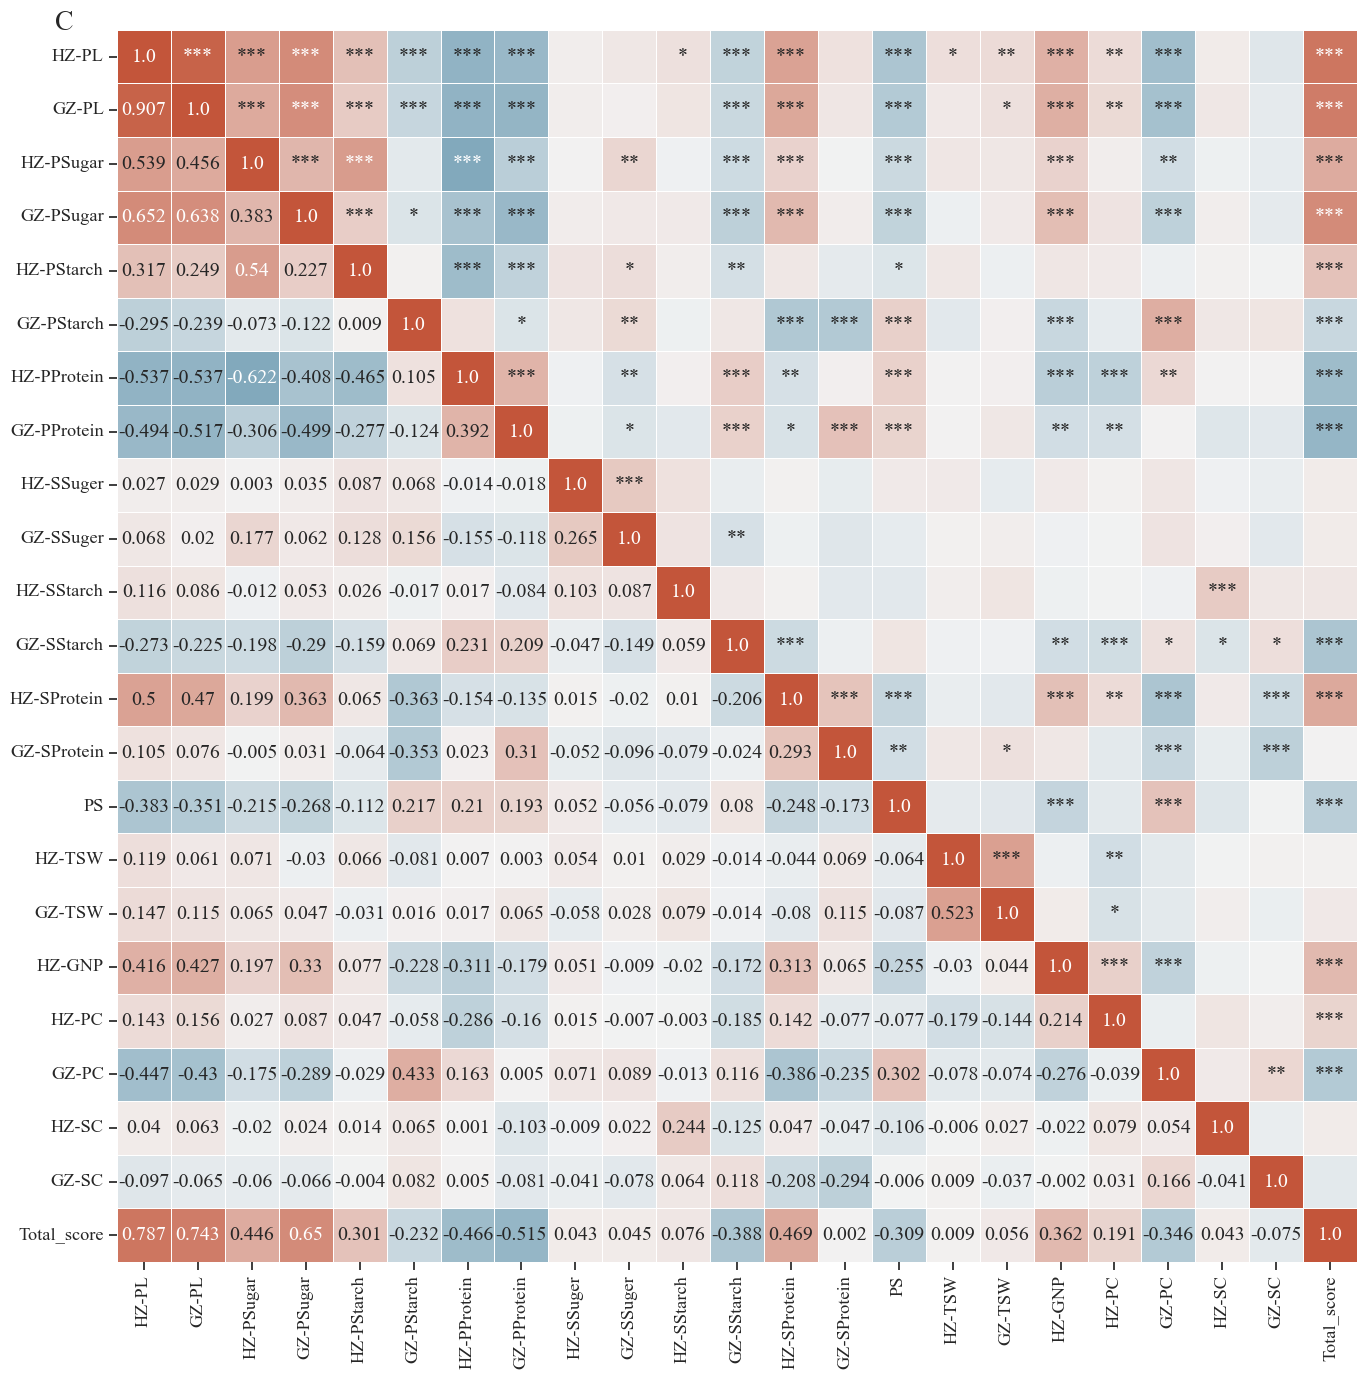

In [4]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=1.2, rc={'figure.figsize':(16,16)}, style="ticks")

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]

def letter_annotation(ax, xoffset, yoffset, letter):

    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
            size=20, weight='bold')

g = sns.heatmap(spear_corr_df, cmap=cmap, cbar=False, 
                vmax=1, center=0, vmin=-1,
                annot=spear_annot, fmt='',
                linewidths=0.5)

letter_annotation(g, -0.05, 1, "C")

plt.savefig(os.path.join(FIG_PATH, 'Fig_1C_corr_pearson.pdf'), format='pdf', bbox_inches='tight', transparent=True)

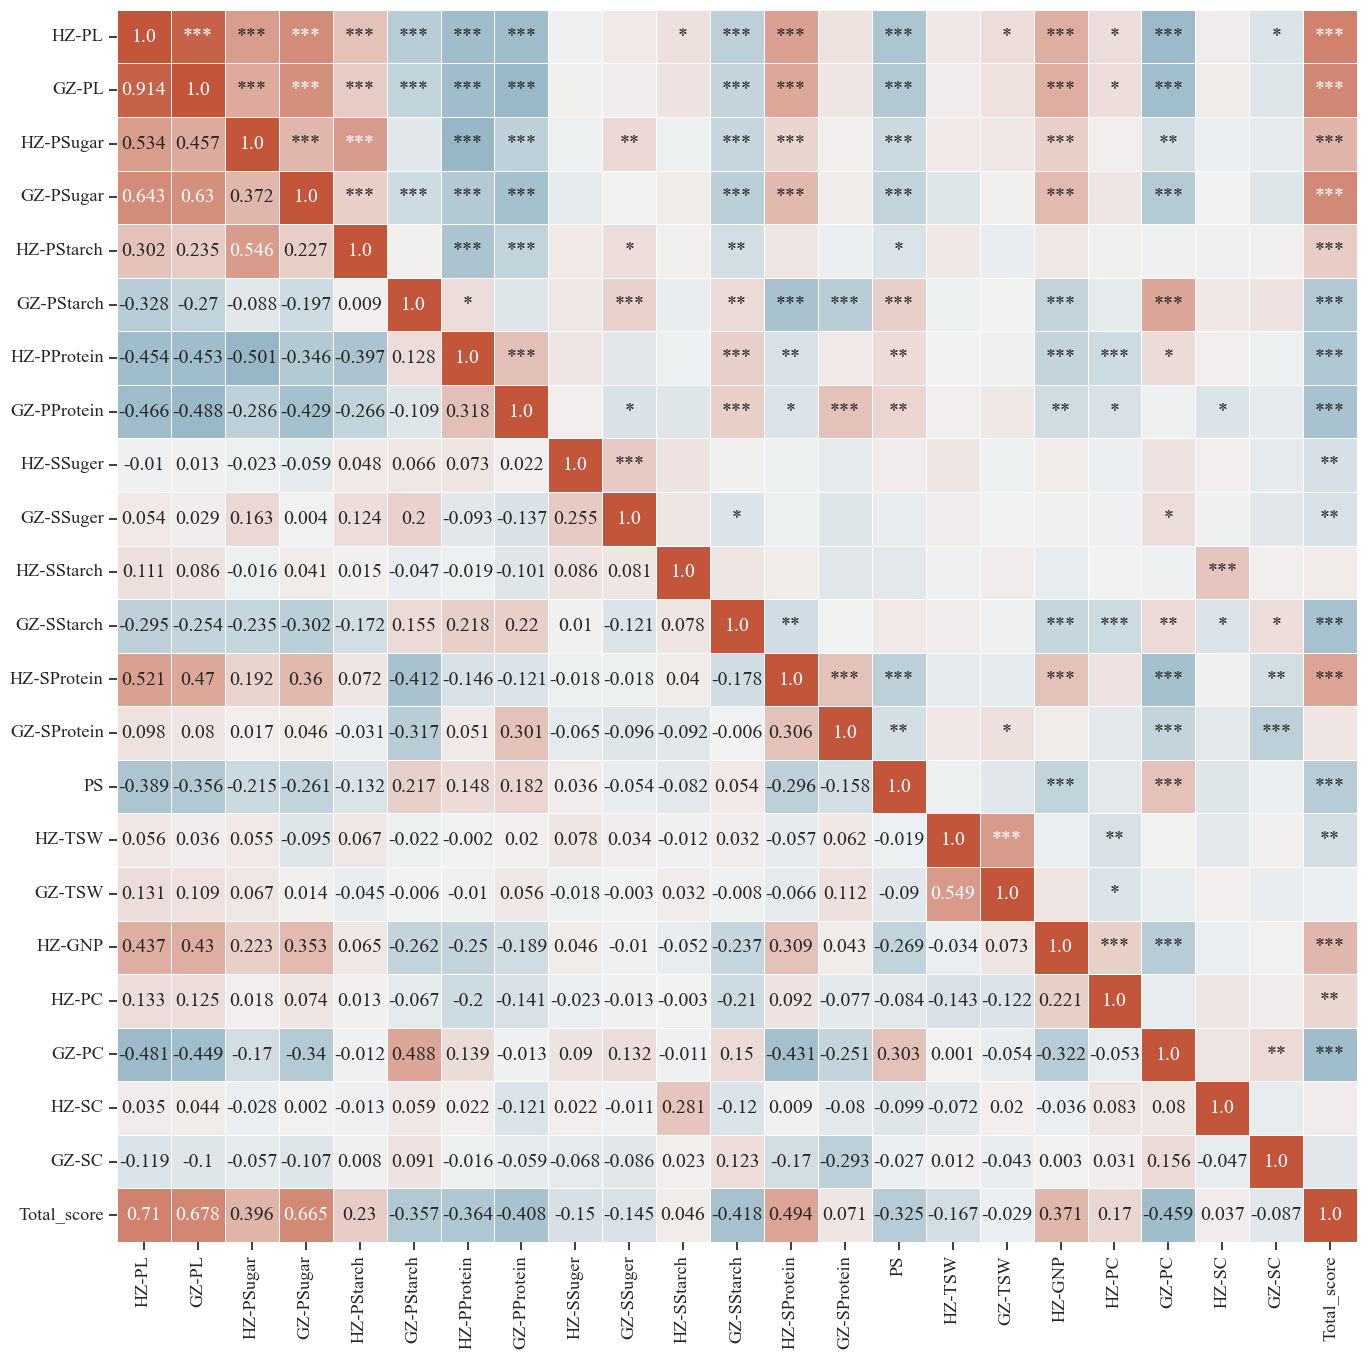

In [5]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=1.2, rc={'figure.figsize':(16,16)}, style="ticks")

mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
"""
def letter_annotation(ax, xoffset, yoffset, letter):

    mpl.rcParams['font.family'] = prop.get_name()
    mpl.rcParams['font.sans-serif'] = ["Times New Roman"]
    ax.text(xoffset, yoffset, letter, transform=ax.transAxes,
            size=20, weight='bold')
"""

g = sns.heatmap(pear_corr_df, cmap=cmap, cbar=False, 
                vmax=1, center=0, vmin=-1,
                annot=pear_annot, fmt='',
                linewidths=0.5)

#letter_annotation(g, -0.05, 1, "C")

#plt.savefig(os.path.join(FIG_PATH, 'fig_1_corr_pearson_RV2.pdf'), format='pdf', bbox_inches='tight', transparent=True)

In [20]:
for col in phenos_add_score.columns:
    res = stats.spearmanr(phenos_add_score["Total_score"].values, phenos_add_score[col].values, nan_policy="omit")
    print("Total_score", col, res.statistic, res.pvalue)

Total_score HZ-PL 0.7873223807067783 3.4421017281546654e-73
Total_score GZ-PL 0.7434873764935622 1.6289233974057078e-57
Total_score HZ-PSugar 0.44614532549287655 4.9249200614318475e-18
Total_score GZ-PSugar 0.6503432821827538 2.040573275549452e-38
Total_score HZ-PStarch 0.30132972925551743 1.592894354422005e-08
Total_score GZ-PStarch -0.23172712019324002 4.261508365408687e-05
Total_score HZ-PProtein -0.4660616041961902 1.6039895710814994e-19
Total_score GZ-PProtein -0.5154352007537989 2.2700649319868316e-22
Total_score HZ-SSuger 0.04295122097066776 0.4326077326228358
Total_score GZ-SSuger 0.04489847383469452 0.41342236281667033
Total_score HZ-SStarch 0.07640544236742113 0.1623056443828616
Total_score GZ-SStarch -0.3881601841727503 1.8699181706274874e-13
Total_score HZ-SProtein 0.4686942728877215 9.428672183411896e-20
Total_score GZ-SProtein 0.0016634794047056926 0.9758379705068817
Total_score PS -0.30934289292335637 5.103524567553598e-09
Total_score HZ-TSW 0.009057588757699906 0.868618

In [3]:
for col in phenos_add_score.columns:
    res = stats.spearmanr(phenos_add_score["Total_score"].values, phenos_add_score[col].values, nan_policy="omit")
    print("Total_score", col, res.statistic, res.pvalue)

Total_score HZ-PL 0.7873223807067783 3.4421017281546654e-73
Total_score GZ-PL 0.7434873764935622 1.6289233974057078e-57
Total_score HZ-PSugar 0.44614532549287655 4.9249200614318475e-18
Total_score GZ-PSugar 0.6503432821827538 2.040573275549452e-38
Total_score HZ-PStarch 0.30132972925551743 1.592894354422005e-08
Total_score GZ-PStarch -0.23172712019324002 4.261508365408687e-05
Total_score HZ-PProtein -0.4660616041961902 1.6039895710814994e-19
Total_score GZ-PProtein -0.5154352007537989 2.2700649319868316e-22
Total_score HZ-SSuger 0.04295122097066776 0.4326077326228358
Total_score GZ-SSuger 0.04489847383469452 0.41342236281667033
Total_score HZ-SStarch 0.07640544236742113 0.1623056443828616
Total_score GZ-SStarch -0.3881601841727503 1.8699181706274874e-13
Total_score HZ-SProtein 0.4686942728877215 9.428672183411896e-20
Total_score GZ-SProtein 0.0016634794047056926 0.9758379705068817
Total_score PS -0.30934289292335637 5.103524567553598e-09
Total_score HZ-TSW 0.009057588757699906 0.868618